In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os

# Change the current directory to where the zip file is located
os.chdir('/content/drive/MyDrive')

In [ ]:
# Unzip the file (replace 'state-farm-distracted-driver-detection (1) - Copy.zip' with the actual filename)
!unzip '/content/drive/MyDrive/state-farm-distracted-driver-detection (1) - Copy.zip'


Streaming output truncated to the last 5000 lines.
  inflating: state-farm-distracted-driver-detection (1) - Copy/imgs/train/c7/img_56779.jpg  
  inflating: state-farm-distracted-driver-detection (1) - Copy/imgs/train/c7/img_56849.jpg  
  inflating: state-farm-distracted-driver-detection (1) - Copy/imgs/train/c7/img_56899.jpg  
  inflating: state-farm-distracted-driver-detection (1) - Copy/imgs/train/c7/img_56938.jpg  
  inflating: state-farm-distracted-driver-detection (1) - Copy/imgs/train/c7/img_5706.jpg  
  inflating: state-farm-distracted-driver-detection (1) - Copy/imgs/train/c7/img_57076.jpg  
  inflating: state-farm-distracted-driver-detection (1) - Copy/imgs/train/c7/img_57122.jpg  
  inflating: state-farm-distracted-driver-detection (1) - Copy/imgs/train/c7/img_57137.jpg  
  inflating: state-farm-distracted-driver-detection (1) - Copy/imgs/train/c7/img_5715.jpg  
  inflating: state-farm-distracted-driver-detection (1) - Copy/imgs/train/c7/img_57278.jpg  
  inflating: state-fa

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Define the paths to your dataset
train_dir ='/content/state-farm-distracted-driver-detection (1) - Copy/imgs/train'
test_dir = '/content/state-farm-distracted-driver-detection (1) - Copy/imgs/test'

# Set hyperparameters
batch_size = 32
epochs = 10
# Data preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'
)

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'
)

# Create the MobileNet base model
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
num_classes = 10
# Add custom layers for classification
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)  # Replace num_classes with the number of classes in your dataset

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(lr=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=test_generator,
)

# Save the trained model
model.save('distracted_driver_mobilenet4.h5')

Found 22424 images belonging to 10 classes.
Found 0 images belonging to 0 classes.
17225924/17225924 [==============================] - 1s 0us/step


Epoch 1/10
701/701 [==============================] - 372s 514ms/step - loss: 0.6663 - accuracy: 0.7912
Epoch 2/10
701/701 [==============================] - 345s 492ms/step - loss: 0.2745 - accuracy: 0.9121
Epoch 3/10
701/701 [==============================] - 340s 485ms/step - loss: 0.2303 - accuracy: 0.9247
Epoch 4/10
701/701 [==============================] - 344s 490ms/step - loss: 0.1912 - accuracy: 0.9379
Epoch 5/10
701/701 [==============================] - 342s 487ms/step - loss: 0.1611 - accuracy: 0.9475
Epoch 6/10
701/701 [==============================] - 343s 489ms/step - loss: 0.1431 - accuracy: 0.9528
Epoch 7/10
701/701 [==============================] - 340s 485ms/step - loss: 0.1273 - accuracy: 0.9591
Epoch 8/10
701/701 [==============================] - 345s 492ms/step - loss: 0.1182 - accuracy: 0.9620
Epoch 9/10
701/701 [==============================] - 350s 499ms/step - loss: 0.1062 - accuracy: 0.9644
Epoch 10/10
701/701 [==============================] - 348s 496m

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 1s 770ms/step


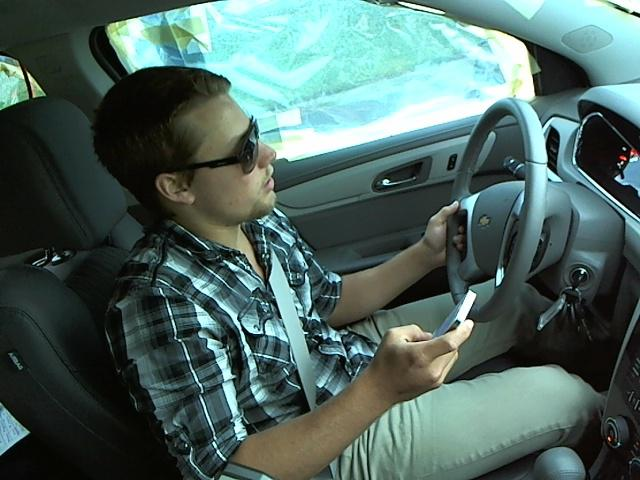

Predicted class: Texting on right hand


In [1]:
import numpy as np
import cv2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
from IPython.display import Image, display

# Load the trained model
try:
    model = load_model('mobilenet.h5')
except Exception as e:
    print(f"Error loading the model: {str(e)}")
    exit()

# Define a function to preprocess a single image
def preprocess_image(image_path, target_size):
    try:
        img = image.load_img(image_path, target_size=target_size)
        img = image.img_to_array(img)
        img = np.expand_dims(img, axis=0)
        img /= 255.0  # Normalize the image
        return img
    except Exception as e:
        print(f"Error preprocessing image: {str(e)}")
        exit()

# Define a function to make predictions
def predict_image_class(model, image_path, class_labels):
    # Preprocess the image
    processed_image = preprocess_image(image_path, model.input_shape[1:3])

    # Make predictions
    try:
        predictions = model.predict(processed_image)
        predicted_class = np.argmax(predictions)
    except Exception as e:
        print(f"Error making predictions: {str(e)}")
        exit()

    if predicted_class < 0 or predicted_class >= len(class_labels):
        print("Error: Predicted class index out of bounds")
        exit()

    # Get the predicted class label
    predicted_label = class_labels[predicted_class]

    return predicted_label

# Path to the image you want to make predictions on
image_path = 'demoImg.jpg'  # Replace with the actual image path

# Define your class labels
class_labels = ['Safe driving', 'Texting on right hand', 'Cell-phone talking on right-hand', 'Texting on left Hand',
                'Cellphone talking on left-hand', 'Operating the radio', 'Drinking', 'Reaching Behind', 'Hair and makeup',
                'Talking to passengers']  # Replace with your class labels

# Call the predict_image_class function
predicted_label = predict_image_class(model, image_path, class_labels)

# Display the image using IPython.display
display(Image(filename=image_path))

# Print the predicted class label
print(f"Predicted class: {predicted_label}")
